# Import

In [1]:
try:
    from egrabber import *
except:
    pass
import numpy as np
import time
import cv2
import ctypes
from tqdm import tqdm
import winsound
import warnings
from datetime import datetime
from scipy import signal
import itertools
import math
from functools import partial
import math
import winsound
from scipy.signal import butter, filtfilt,resample
from scipy.io.wavfile import write

# local import 
import sys
from pathlib import Path
if str(Path.cwd().parent) not in sys.path:
    sys.path.insert(0, str(Path.cwd().parent))

from utils.recover_core_lib import *

SWP_NOMOVE = 0x0002
SWP_NOSIZE = 0x0001
HWND_TOPMOST = -1

import traceback

import matplotlib.pyplot as plt

from threading import Thread
import os

signal_crop = None
if 'run_opt' not in locals():
    run_opt = {}
    
if 'run_opt_recovery' not in locals():
    run_opt_recovery = {}


%matplotlib notebook

FONT = cv2.FONT_HERSHEY_SIMPLEX

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

c:\Users\ethantu\good-vibrations\.venv\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


# **LIB**

In [2]:
class MikrotronCamera(object):

    def __init__(self, info_field=False, ):
        self.gentl   = EGenTL()
        self.grabber = EGrabber(self.gentl)
        self.grabber.remote.set("CxpLinkConfiguration", "CXP12_X4")
        self.grabber.stream.set('BufferPartCount', 1)
        self.update_size()
        self.grabber.realloc_buffers(20)
        #self.grabber.start()

        self.info_field = info_field
        if self.info_field:
            self.grabber.remote.set("InfoFieldTimeStampEnable", True)
            self.grabber.remote.set("InfoFieldFrameCounterEnable", True)
            self.grabber.remote.set("InfoFieldRoiEnable", True)
            
    def set_buffer_part_count(self, buffer_count):
        self.grabber.stream.set('BufferPartCount', buffer_count)
        self.grabber.realloc_buffers(20)
    
    def get_exposure(self):
        return self.grabber.remote.get("ExposureTime")
        
    def set_exposure(self, exposure_value):
        self.grabber.remote.set("ExposureTime", exposure_value)

    def get_frame_rate(self):
        return self.grabber.remote.get("AcquisitionFrameRate")
    
    def set_frame_rate(self, frame_rate):
        self.grabber.remote.set("AcquisitionFrameRate", frame_rate)
    
    def get_max_frame_rate(self):
        return self.grabber.remote.get("AcquisitionFrameRateMax")

    def get_acquisition_mode(self):
        return self.grabber.remote.get("AcquisitionMode")
    
    def set_gain(self, gain_value):
        self.grabber.remote.set("Gain", gain_value)
    
    def start_acquisition(self):
        self.grabber.remote.set("AcquisitionMode", "Continuous")
        self.grabber.remote.execute("AcquisitionStart")
        while not self.grabber.remote.done("AcquisitionStart"):
            pass
    
    def stop_acquisition(self):
        self.grabber.remote.execute("AcquisitionStop")
        while not self.grabber.remote.done("AcquisitionStop"):
            pass
        
    def reset_buffer(self):
        self.update_size()
        self.grabber.stop()
        self.grabber.realloc_buffers(20) 
        self.grabber.start()
        
    # ---------- global ROI -----------
    
    def get_global_roi(self):
        x = self.grabber.remote.get("OffsetX")
        w = self.grabber.remote.get("Width")
        y = self.grabber.remote.get("OffsetY")
        h = self.grabber.remote.get("Height")
        return (x, y, w, h)

    def reset_global_roi(self):
        self.grabber.remote.set("MultiROILUTModeEn", False)
        self.grabber.remote.set("OffsetX", 0)
        self.grabber.remote.set("OffsetY", 0)
        self.grabber.remote.set("Width", 1920)
        self.grabber.remote.set("Height", 1080)   
        self.reset_buffer()        

    def set_global_roi(self, x, y, w, h):
        x1, y1, x2, y2 = x, y, x + w, y + h
        if w < 128 or w % 16 != 0 or w > 1920:
            raise Exception("Set Width has to be greater than 128 px, and incremented by 16")
        #if h < 8 or h % 4 != 0 or h > 1080:
        #    raise Exception("Set Height has to be greater than 8 px, and incremented by 8")
        if x % 16 != 0:
            raise Exception("Set OffsetX has to be greater than 16 px, and incremented by 16")
        if y % 4 != 0:
            raise Exception("Set OffsetY has to be greater than 8 px, and incremented by 4")
        
        if x1 < 0 or y1 < 0 or x2 > 1920 or y2 > 1080:
            raise Exception("ROI out of sensor limits!")

        ## this order matters, set the height to a smaller value first
        ## then it lets you set the offset
        self.grabber.remote.set("Width", w)
        self.grabber.remote.set("Height", h)
        self.grabber.remote.set("OffsetX", x)
        self.grabber.remote.set("OffsetY", y)
        
        self.reset_buffer()
        
    def set_global_roi_noy(self, x, y, w, h):
        x1, y1, x2, y2 = x, y, x + w, y + h
        if w < 128 or w % 16 != 0 or w > 1920:
            raise Exception("Set Width has to be greater than 128 px, and incremented by 16")
        #if h < 8 or h % 4 != 0 or h > 1080:
        #    raise Exception("Set Height has to be greater than 8 px, and incremented by 8")
        if x % 16 != 0:
            raise Exception("Set OffsetX has to be greater than 16 px, and incremented by 16")
        if y % 4 != 0:
            raise Exception("Set OffsetY has to be greater than 8 px, and incremented by 4")
        
        if x1 < 0 or y1 < 0 or x2 > 1920 or y2 > 1080:
            raise Exception("ROI out of sensor limits!")

        ## this order matters, set the height to a smaller value first
        ## then it lets you set the offset
        self.grabber.remote.set("Width", w)
        self.grabber.remote.set("Height", h)
        self.grabber.remote.set("OffsetX", x)
        
        self.reset_buffer()
    
    # ---------- rows -----------
    
    def set_rows(self, row_idxs):
        
        self.grabber.remote.set("MultiROILUTModeEn", False)
        H = len(row_idxs) * 2
        if H % 4 != 0:
            raise Exception("Set H is not a multiple of 4")

        for i, idx in enumerate(row_idxs):
            self.grabber.remote.set("MultiROILUTIndex", i)
            self.grabber.remote.set("MultiROILUTValue", int(idx))
        
        self.grabber.remote.set("Height", H)
        self.grabber.remote.set("MultiROILUTModeEn", True)
        self.reset_buffer()

    '''    
    def set_rows_with_index(self, indexed_rows):
        
        self.grabber.remote.set("MultiROILUTModeEn", False)

        for idx, row in indexed_rows:
            self.grabber.remote.set("MultiROILUTIndex", idx)
            self.grabber.remote.set("MultiROILUTValue", int(row))
        
        self.grabber.remote.set("MultiROILUTModeEn", True)
        self.reset_buffer()

    def change_row(self, register_idx, row):
        self.grabber.remote.set("MultiROILUTIndex", register_idx)
        self.grabber.remote.set("MultiROILUTValue", row)

    def unset_rows(self):
        self.grabber.remote.set("MultiROILUTModeEn", False)
        for idx, row in enumerate(range(0, 540)):
            self.grabber.remote.set("MultiROILUTIndex", idx)
            self.grabber.remote.set("MultiROILUTIndex", 0)
        
        self.grabber.remote.set("Height", 1080)
        self.update_size()
    '''

    def update_size(self):
        self.w = self.grabber.stream.get('Width')
        self.h = self.grabber.stream.get('Height')

    def get_im_size(self):
        return self.w, self.h
    
def get_max_possible_exposure(fps):
    exp = (1000.0/fps) * 1000
    exp = int(exp) - 1
    return exp

'''New capture functions'''
class CaptureFrameThread2(Thread):
    def __init__(self, cam, N_frames, IMG_H, IMG_W):
        super(CaptureFrameThread2, self).__init__()
        self.cam      = cam
        self.frames_per_buffer = cam.grabber.stream.get('BufferPartCount')
        self.N_frames = int(np.ceil(N_frames/self.frames_per_buffer))
        self.w = cam.grabber.stream.get('Width')
        self.h = cam.grabber.stream.get('Height')
        self.h_roi = cam.get_global_roi()[-1]        
        self.frames   = np.empty((self.N_frames, self.h, self.w), dtype=np.uint8)

    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        c = 1
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1, w))

    def run(self):
        for i in range(self.N_frames):
            with Buffer(self.cam.grabber, timeout=5000) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                delivered  = buffer.get_info(BUFFER_INFO_CUSTOM_NUM_DELIVERED_PARTS, INFO_DATATYPE_SIZET)
                proc = 0
                while proc < delivered:
                    imagePtr = buffer_ptr + proc * image_size
                    img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size)
                    self.frames[i,proc*self.h_roi:(proc+1)*self.h_roi] = img.copy()
                    proc = proc + 1
    def read(self):
        video = self.frames.reshape(self.N_frames * self.frames_per_buffer, self.h_roi, self.w)
        return video, None
    
class CaptureFrameThread(Thread):
    def __init__(self, cam, N_frames, IMG_H, IMG_W, copy=True):
        super(CaptureFrameThread, self).__init__()
        self.cam = cam
        self.N_frames = N_frames
        self.copy = copy
        self.frames = np.empty((N_frames, IMG_H, IMG_W), dtype=np.uint8)
        self.timestamps = np.empty((N_frames,), dtype=np.int64)
        self.frame_counter = 0

    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        c = 1
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1, w))

    def run(self):
        for i in range(self.N_frames):
            with Buffer(self.cam.grabber, timeout=500) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                img = self.__ptr_to_ndarray(buffer_ptr, self.cam.w, image_size)
                ts = time.perf_counter_ns() // 1000000
                self.frames[i] = img.copy()
                self.timestamps[i] = ts
                self.frame_counter = (self.frame_counter + 1) % 256
    def read(self):
        return self.frames, self.timestamps

def capture_N_frames(cam, N_frames, IMG_H, IMG_W, dtype=np.uint8):
    cam.grabber.flush_buffers()
    cam.grabber.start()
    thread = CaptureFrameThread2(cam, N_frames, IMG_H, IMG_W)
    thread.start()
    thread.join()
    frames, timestamps = thread.read()
    cam.grabber.stop()
    cam.grabber.flush_buffers()
    return frames, timestamps

def save_data(all_data, N, fps, flag="custom_rows", prefix="frame", unshuffle=False, row_manip=None):
    os.makedirs(f"output/{flag}_{fps}", exist_ok=True)
    for i in range(N):
        img = all_data[i, :, :]
        if unshuffle:
            img = row_manip.unshuffle_camera_rows(img)
        img = cv2.cvtColor(img, cv2.COLOR_BayerGRBG2BGR)
        cv2.imwrite(f"output/{flag}_{fps}/{prefix}.{i}.jpg", img)
        # exit()
        
def create_hann_window(image_shape,margin,dtype =cv2.CV_32F):
    def pad_image(image, h_pad, v_pad):
        padded_image = cv2.copyMakeBorder(image, v_pad, v_pad, h_pad, h_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        return padded_image
    
    h,w  = image_shape
    hannW = cv2.createHanningWindow((w - 2*margin, h - 2*margin), dtype)
    hannW = pad_image(hannW,margin,margin)
    return hannW

def stretch_contrast(image,minmax=None):
    if minmax is None:
        min_val = np.min(image)
        max_val = np.max(image)
    else:
        min_val,max_val = minmax
    stretched = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)    
    return stretched

def select_rectangle(image):
    rect_coords = cv2.selectROI("Image", image, fromCenter=False, showCrosshair=True)

    # Close the window
    cv2.destroyAllWindows()

    # Return the rectangle image_showcoordinates
    return rect_coords

# Connect & configure camera

In [3]:
cam = MikrotronCamera(info_field=False)
run_opt['cam_params'] = {}

GenTLException: GenTL error -1

In [ ]:
cam.set_buffer_part_count(10000)

## Set exposure and frame rate

### Set low frame rate for calibration

In [ ]:
run_opt['cam_params']['camera_FPS'] = 5000
run_opt['cam_params']['exposure']   = 100
run_opt['cam_params']['gain']   = 1


cam.set_frame_rate(run_opt['cam_params']['camera_FPS'])
cam.set_exposure(run_opt['cam_params']['exposure'])
cam.set_gain(run_opt['cam_params']['gain'])

print(f'ROI = {cam.get_global_roi()}')
print('Image height = {:} [px]'.format(cam.grabber.stream.get('Height')))
print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
print(f'exposure  = {cam.get_exposure()} [us]')
print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

cam.set_buffer_part_count(1)
if 1:
    run_opt['cam_params']['get_global_roi'] = cam.get_global_roi()
    run_opt['cam_params']['get_frame_rate'] = cam.get_frame_rate()
    run_opt['cam_params']['get_max_frame_rate'] = cam.get_max_frame_rate()
    run_opt['cam_params']['get_exposure'] = cam.get_exposure()

ROI = (320, 0, 1056, 180)
Image height = 180 [px]
frame rate  = 5000 [FPS]
exposure  = 100 [us]
max frame rate = 13103 [Hz]


### Set high frame rate for capturing

In [ ]:
run_opt['cam_params']['camera_FPS'] = 225000 #133000 
run_opt['cam_params']['exposure']   = 3
run_opt['cam_params']['gain']   = 3

cam.set_frame_rate(run_opt['cam_params']['camera_FPS'])
cam.set_exposure(run_opt['cam_params']['exposure'])
cam.set_gain(run_opt['cam_params']['gain'])

print(f'ROI = {cam.get_global_roi()}')
print('Image height = {:} [px]'.format(cam.grabber.stream.get('Height')))
print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
print(f'exposure  = {cam.get_exposure()} [us]')
print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

if 1:
    run_opt['cam_params']['get_global_roi'] = cam.get_global_roi()
    run_opt['cam_params']['get_frame_rate'] = cam.get_frame_rate()
    run_opt['cam_params']['get_max_frame_rate'] = cam.get_max_frame_rate()
    run_opt['cam_params']['get_exposure'] = cam.get_exposure()

ROI = (512, 0, 1056, 4)
Image height = 4 [px]
frame rate  = 225000 [FPS]
exposure  = 3 [us]
max frame rate = 225000 [Hz]


## Reset global ROI

In [ ]:
cam.reset_global_roi()

## Set global ROI

In [ ]:
cam.grabber.flush_buffers()
cam.grabber.start()
frame_recording, times = capture_N_frames(cam, 10, *cam.get_im_size()[::-1])
cam.grabber.stop()
cam.grabber.flush_buffers()


rect_coords = select_rectangle(frame_recording[0])

x, y, width, height = rect_coords
global_ROI = (int(np.round(x/16)*16),
              int(np.round(y/4)*4),
              int(np.round(width/16)*16),
              int(np.round(height/4)*4))


image_show = frame_recording[0].copy()
x, y, width, height = global_ROI
cv2.rectangle(image_show, (x, y), (x + width, y + height), (0, 255, 0), 2)
print(f'rect_coords: (x,y,width,height) = {rect_coords}')
print(f'global_ROI:  (x,y,width,height) = {global_ROI}')
plt.figure()
plt.imshow(image_show)

### Set global ROI

In [ ]:
global_ROI =(784, 688, 432, 40)

In [ ]:
cam.set_global_roi(*global_ROI)

print(f'ROI = {cam.get_global_roi()}')
print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
print(f'exposure  = {cam.get_exposure()} [us]')
print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

ROI = (784, 688, 432, 40)
frame rate  = 50 [FPS]
exposure  = 22 [us]
max frame rate = 52715 [Hz]


## Set multiple ROIs

[(580, 134), (909, 290), (924, 459), (926, 626), (933, 789), (945, 961)]
[(314, 145), (1384, 966)]


<IPython.core.display.Javascript object>


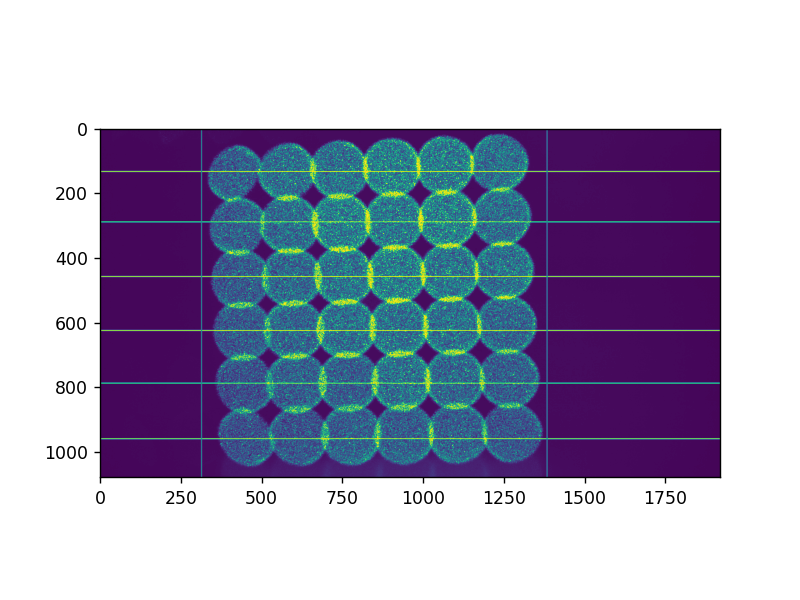

In [ ]:
run_opt_multiROIs = {}
run_opt_multiROIs['N_ROIs'] = 6

frame_recording, times = capture_N_frames(cam, 10, *cam.get_im_size()[::-1])

def select_points_horiz(event, x, y, flags, param):
    global points, num_points
    
    # On left mouse button click
    if event == cv2.EVENT_LBUTTONDOWN:
        # Store the point
        points.append((x, y))
        
        # Draw a horizontal line across the row of the clicked point
        cv2.line(image, (0, y), (image.shape[1], y), 255, 2)
        cv2.imshow("Image", image)
        num_points += 1
        
        # If we have reached the desired number of points, stop
        if num_points >= param:
            cv2.setMouseCallback("Image", lambda *args : None)  # Disable further callbacks
            cv2.destroyAllWindows()
            
def select_points_vert(event, x, y, flags, param):
    global points, num_points
    
    # On left mouse button click
    if event == cv2.EVENT_LBUTTONDOWN:
        # Store the point
        points.append((x, y))
        
        # Draw a horizontal line across the row of the clicked point
        cv2.line(image, (x, 0), (x,image.shape[0]), 255, 2)
        cv2.imshow("Image", image)
        num_points += 1
        
        # If we have reached the desired number of points, stop
        if num_points >= param:
            cv2.setMouseCallback("Image", lambda *args : None)  # Disable further callbacks
            cv2.destroyAllWindows()

def get_points_from_image(image_np, N,select_points_fun):
    global image, points, num_points
    points = []  # Reset points list
    num_points = 0  # Reset point counter
    image = image_np.copy()  # Work on a copy of the image
    
    # Display the image and set the mouse callback function
    cv2.imshow("Image", image)
    cv2.setMouseCallback("Image", select_points_fun, param=N)
    
    # This ensures the window can update properly
    while True:
        # Wait for a key press
        key = cv2.waitKey(1) & 0xFF
        # If all points are selected or the user presses the 'q' key, exit loop
        if num_points >= N or key == ord('q'):
            break
    
    cv2.destroyAllWindows()
    
    return points

image                = stretch_contrast(frame_recording[-1].copy())

points = []
num_points = 0
selected_points      = get_points_from_image(image, run_opt_multiROIs['N_ROIs'],select_points_horiz)

points = []
num_points = 0
selected_points_crop = get_points_from_image(image, 2, select_points_vert)

print(selected_points)
print(selected_points_crop)

for x,y in selected_points:
    cv2.line(image, (0, y), (image.shape[1], y), 255, 2)
    
for x,y in selected_points_crop:
    cv2.line(image, (x, 0), (x,image.shape[0]), 128, 2)

plt.figure()
plt.imshow(image)

### Compute ROIs

In [ ]:
run_opt_multiROIs['ROI_height']         = 30
run_opt_multiROIs['total_image_height'] = run_opt_multiROIs['N_ROIs'] * run_opt_multiROIs['ROI_height']

# get ROI list
ROI_list   = []
ROI_values = []
for x,y in selected_points:
    ROI_start = (y - run_opt_multiROIs['ROI_height']//2)
    ROI_start += ROI_start % 2
    ROI_end   = ROI_start + run_opt_multiROIs['ROI_height']
    ROI_list.append((ROI_start,ROI_end))
    ROI_vals  = np.arange(ROI_start,ROI_end,2)//2
    ROI_values.append(ROI_vals)

ROI_values_single_list = np.asarray(ROI_values).flatten()
print(f'ROIs list:\n{ROI_list}'); print('')
print(f'values per ROI:\n{ROI_values}'); print('')
print(f'all values list:\n{ROI_values_single_list}')
print('Total image height = {}'.format(run_opt_multiROIs['total_image_height']))
print('Max FPS = {} Hz'.format(int(1080/run_opt_multiROIs['total_image_height'] * 2247 * (1000/1024)**4)))

OffsetX = int(np.round(selected_points_crop[0][0]/16)*16)
Width   =  selected_points_crop[1][0] - OffsetX
Width   =  int(np.round(Width/16)*16)

run_opt_multiROIs['global_ROI'] = (OffsetX, 0,Width,run_opt_multiROIs['total_image_height'])
print(run_opt_multiROIs['global_ROI'])

ROIs list:
[(120, 150), (276, 306), (444, 474), (612, 642), (774, 804), (946, 976)]

values per ROI:
[array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74],
      dtype=int32), array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152], dtype=int32), array([222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236], dtype=int32), array([306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320], dtype=int32), array([387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
       400, 401], dtype=int32), array([473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485,
       486, 487], dtype=int32)]

all values list:
[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 387 388 389 390 391 392 393 

### 1. Set ROIs

In [ ]:
cam.set_rows(ROI_values_single_list)

### 3. Set horizontal crop (to further reduce frame size)

In [ ]:
cam.set_global_roi_noy(*run_opt_multiROIs['global_ROI'])

print(f'ROI = {cam.get_global_roi()}')
print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
print(f'exposure  = {cam.get_exposure()} [us]')
print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

ROI = (320, 0, 1056, 180)
frame rate  = 2247 [FPS]
exposure  = 100 [us]
max frame rate = 13103 [Hz]


# 2. Preview

In [ ]:
# DEBUG: interesting pop q option
from threading import Thread, Lock
from collections import deque

class FramePreviewThread(Thread):
    def __init__(self, cam, show_full_frame=True, queue_size=256):
        super(FramePreviewThread, self).__init__()
        self.cam = cam
        self.running = True
        self.show_full_frame = show_full_frame

        self.w = cam.grabber.stream.get('Width')
        self.h = cam.grabber.stream.get('Height')
        self.h_roi = cam.get_global_roi()[-1]

        if self.show_full_frame:
            self.frame = np.zeros((self.h, self.w, 1), dtype=np.uint8)
        else:
            # last displayed frame (fallback if queue empty)
            self.frame = np.zeros((self.h_roi, self.w, 1), dtype=np.uint8)

        # queue of individual ROI frames for fast mode
        self._q = deque(maxlen=queue_size)
        self._lock = Lock()
        self.frame_counter = 0

    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        # reshape to (rows, w)
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1, w))

    def run(self):
        while self.running:
            with Buffer(self.cam.grabber, timeout=500) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                delivered  = buffer.get_info(BUFFER_INFO_CUSTOM_NUM_DELIVERED_PARTS, INFO_DATATYPE_SIZET)

                if self.show_full_frame:
                    proc = 0
                    while proc < delivered:
                        imagePtr = buffer_ptr + proc * image_size
                        img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size)
                        # IMPORTANT: copy while buffer is valid
                        self.frame[proc*self.h_roi:(proc+1)*self.h_roi, :, 0] = img.copy()
                        proc += 1
                        self.frame_counter = (self.frame_counter + 1) % 256
                else:
                    # FAST MODE: enqueue each ROI as its own frame
                    proc = 0
                    while proc < delivered:
                        imagePtr = buffer_ptr + proc * image_size
                        img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size).copy()
                        # store as (h_roi, w, 1)
                        with self._lock:
                            if img.ndim == 2:
                                img = img[:, :, None]
                            self._q.append(img)
                        proc += 1
                        self.frame_counter = (self.frame_counter + 1) % 256

                    # Optional: keep `self.frame` in sync with last enqueued
                    with self._lock:
                        if self._q:
                            self.frame = self._q[-1]

    def read(self):
        # Pop next frame if available (fast mode); else return last frame
        if not self.show_full_frame:
            with self._lock:
                if self._q:
                    self.frame = self._q.popleft()
        return self.frame, self.frame_counter

    def stop(self):
        self.running = False

In [ ]:
class FramePreviewThread(Thread):
    def __init__(self, cam, show_full_frame=True):
        
        super(FramePreviewThread, self).__init__()
        self.cam = cam
        self.running = True

        self.w = cam.grabber.stream.get('Width')
        self.h = cam.grabber.stream.get('Height')
        self.h_roi = cam.get_global_roi()[-1]
        self.show_full_frame = show_full_frame
        
        if self.show_full_frame:
            self.frame = np.zeros((self.h,self.w,1),dtype='uint8')
        else:
            self.frame = np.zeros((self.h_roi,self.w,1),dtype='uint8')
        self.frame_counter = 0
        
    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        c = 1
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1,w))

    def run(self):        
        while self.running:
            with Buffer(self.cam.grabber, timeout=5000) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                delivered  = buffer.get_info(BUFFER_INFO_CUSTOM_NUM_DELIVERED_PARTS, INFO_DATATYPE_SIZET)
                proc = 0
                while proc < delivered:
                    imagePtr = buffer_ptr + proc * image_size
                    img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size)       
                    if self.show_full_frame:
                        self.frame[proc*self.h_roi:(proc+1)*self.h_roi,:,0] = img.copy()
                    else:
                        self.frame = img
                    proc = proc + 1                    
                    self.frame_counter =  (self.frame_counter + 1) % 256

    def read(self):
        return self.frame, self.frame_counter
    
    def stop(self):
        self.running = False

show_full_frame = 0

def preview_camera(cam, resize_factor = 1, gamma_val=2, is_strech_contrast=0,use_crop = None,
                   show_full_frame=True): 
    
    try:
        #cam.stop_acquisition()
        cam.grabber.start()
        #cam.start_acquisition()
        thread = FramePreviewThread(cam,show_full_frame=show_full_frame)
        thread.start()
        cv2.namedWindow("frame")  
        
        # Get the window handle for the OpenCV window
        hwnd = ctypes.windll.user32.FindWindowW(None, "frame")
        
        prev_time = time.time()
        fps = 0

        while(True):
            
            frame,thread_counter = thread.read()

            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)            
            
            if use_crop is not None:
                frame = frame[:,use_crop[0]:use_crop[1]]
                
            if resize_factor!=1:
                frame = cv2.resize(frame,None,fx = resize_factor, fy = resize_factor)
                
            # Calculate FPS
            #curr_time = time.time()
            #time_diff = curr_time - prev_time
            #fps = 1 / (time_diff + 1e-12)
            #prev_time = curr_time
            
            # Add FPS to the frame

            if is_strech_contrast:
                frame_show = stretch_contrast(frame)
            else:
                frame_show = frame
            
            cv2.putText(frame,'cam',(30,30), FONT, 0.75,(255,255,255),2,cv2.LINE_AA)    
            
            #fps_text = f'FPS: {fps:.2f}'
            #cv2.putText(frame_show, fps_text, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv2.LINE_AA)


            cv2.imshow("frame",frame_show)
            
            # Bring the window to the front
            ctypes.windll.user32.SetWindowPos(hwnd, HWND_TOPMOST, 0, 0, 0, 0, SWP_NOMOVE | SWP_NOSIZE)

            key = cv2.waitKeyEx(1) 
            if key==13:
                break
            elif key==32: #space
                pass
            if key==40: # "( key"
                gamma_val-= 0.1
            if key==41: # ") key"
                gamma_val+= 0.1
                
    except Exception:
        traceback.print_exc()
        print('Closing camera thread.') 

    # cleanup
    cv2.destroyAllWindows()
    thread.stop()
    thread.join()
    #cam.stop_acquisition()
    cam.grabber.stop()
    cam.grabber.flush_buffers()

preview_camera(cam,resize_factor=1,gamma_val=2.5,use_crop = None,show_full_frame=show_full_frame,is_strech_contrast=1)

# **Capture N frames**

In [ ]:
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/stairway_9sec.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/DRUM_11s_70to10k_logchirp_quad_intensity_norm.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/never_10K_4sec.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/polyphia_10K_7sec.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/Mary/mary_rock_7p5sec.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/Golden_10sec.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/I_saw_her_standing_there_Beatles__Stereo_6sec.wav'
# wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/Hotel_California_Eagles_4sec.wav'
#wav_filename = r'../../PROJECT_Wall_ripples[Maya]/audio_samples/Mary_9sec.wav'

# wav_filename = 'audio_samples/polyphia_10K_7sec.wav'

# wav_filename = 'audio_samples/thump.wav'

wav_filename = 'audio_samples/DRUM_10_sec_50to2000_logarithmic_chirp_10.2.wav'


winsound.PlaySound(wav_filename, winsound.SND_FILENAME | winsound.SND_ASYNC)

captured 60000 frames


<IPython.core.display.Javascript object>


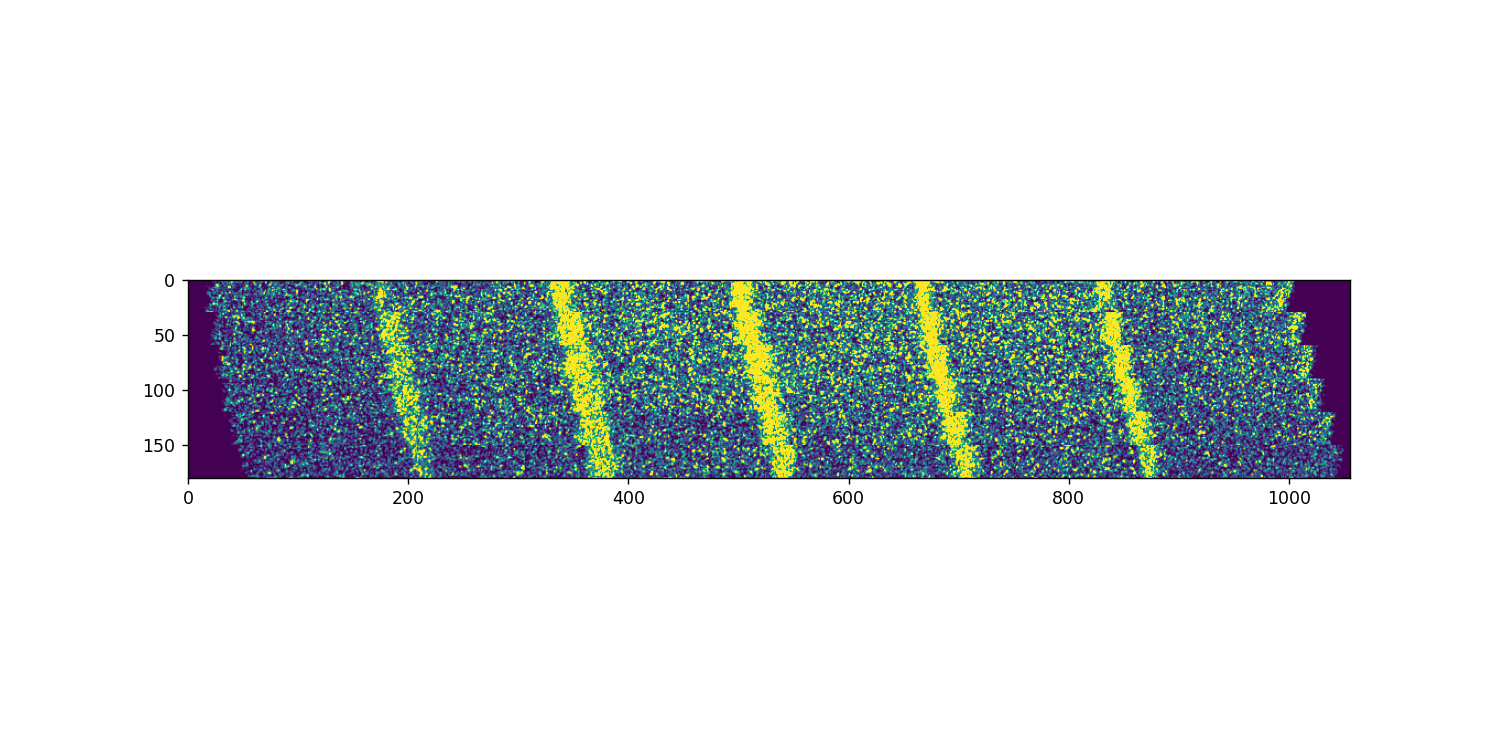

In [ ]:
IS_PLAY_SOUND = True
capture_sec   = 12
N_frames      = int(capture_sec * run_opt['cam_params']['camera_FPS'])

if IS_PLAY_SOUND:
    winsound.PlaySound(wav_filename, winsound.SND_FILENAME | winsound.SND_ASYNC)
frame_recording, times = capture_N_frames(cam, N_frames, *cam.get_im_size()[::-1])

print(f'captured {N_frames} frames')
plt.figure(figsize=(12,6))
MINMAX = (np.percentile(frame_recording[-100:],10),
          np.percentile(frame_recording[-100:],90))

plt.imshow(frame_recording[10],vmin=MINMAX[0],vmax=MINMAX[1])

captured 562500 frames


<IPython.core.display.Javascript object>


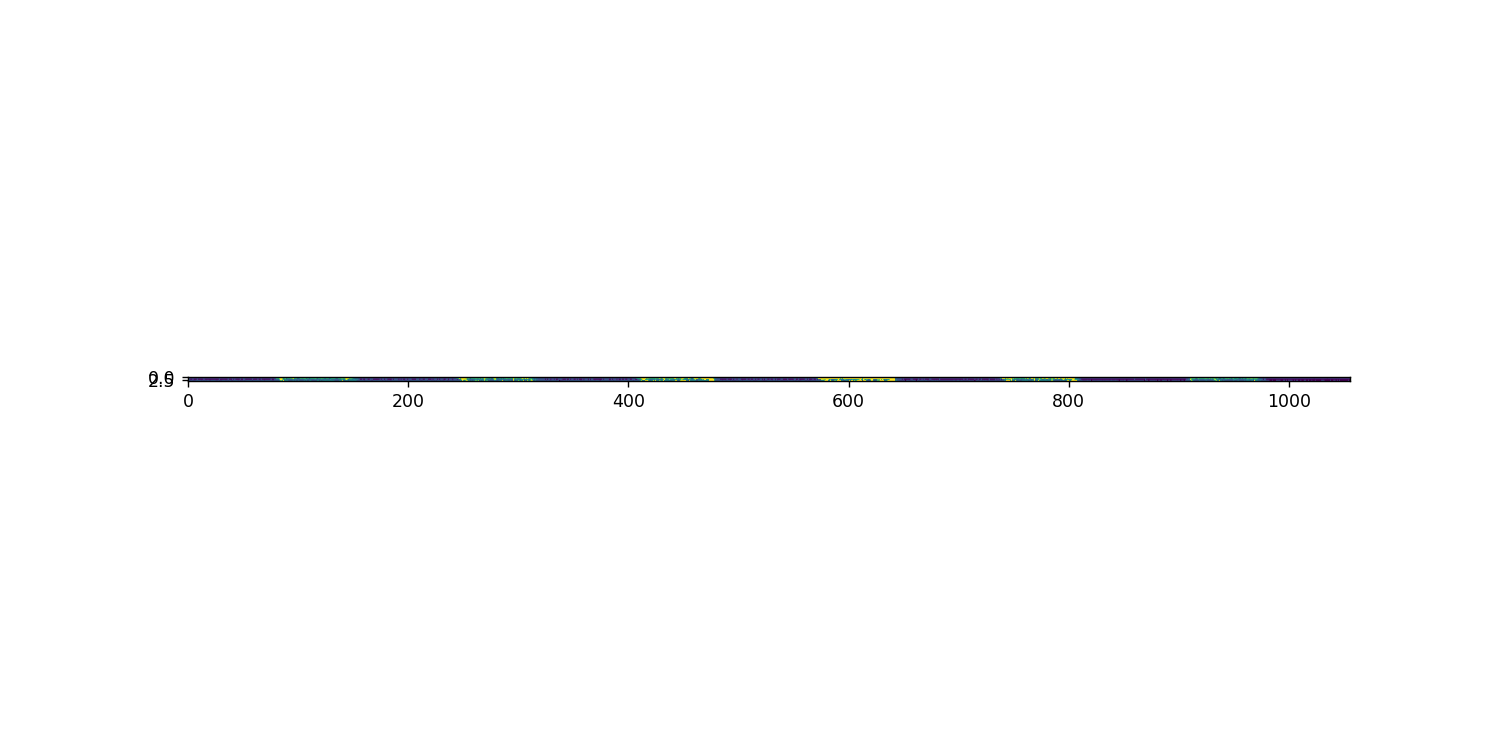

In [ ]:
IS_PLAY_SOUND = False
capture_sec   = 2.5
N_frames      = int(capture_sec * run_opt['cam_params']['camera_FPS'])

if IS_PLAY_SOUND:
    winsound.PlaySound(wav_filename, winsound.SND_FILENAME | winsound.SND_ASYNC)
frame_recording, times = capture_N_frames(cam, N_frames, *cam.get_im_size()[::-1])

print(f'captured {N_frames} frames')
plt.figure(figsize=(12,6))
MINMAX = (np.percentile(frame_recording[-100:],10),
          np.percentile(frame_recording[-100:],90))

plt.imshow(frame_recording[10],vmin=MINMAX[0],vmax=MINMAX[1])

<IPython.core.display.Javascript object>


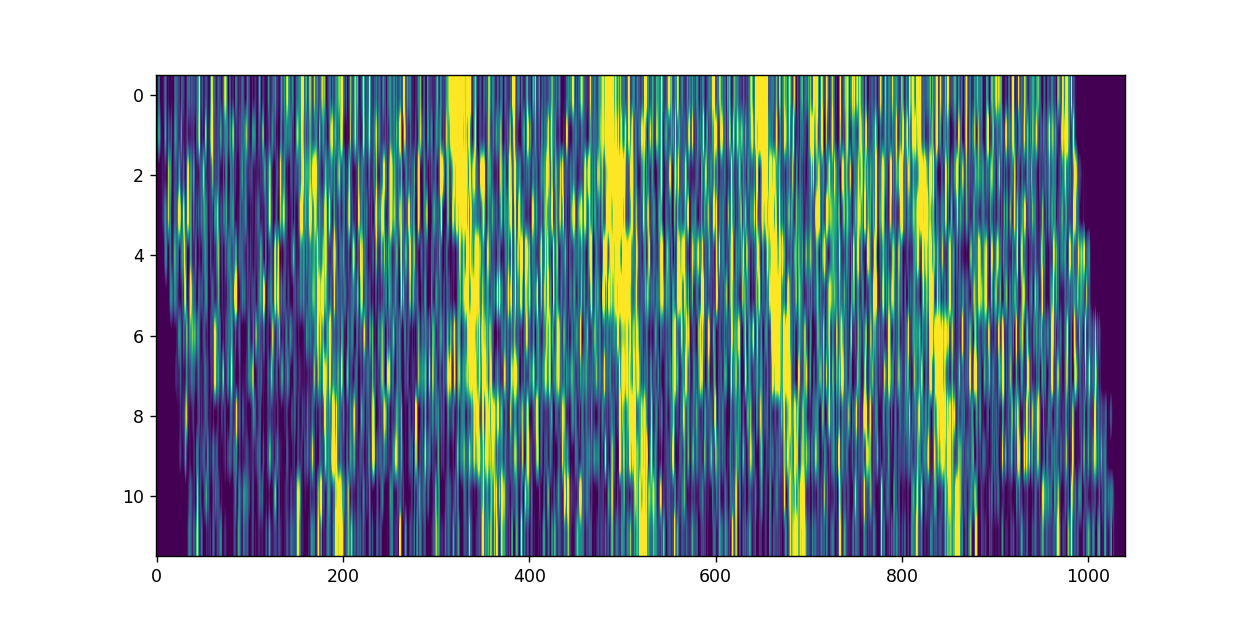

In [ ]:
plt.close()
plt.figure(figsize=(10,5))
plt.imshow(frame_recording[1000],vmin=MINMAX[0],vmax=MINMAX[1], aspect='auto')
plt.show()

## Show captured video

In [ ]:
from lib.opencv_video_utils import videoPlayer

class videoPlayerv2(videoPlayer):
    def additional_loop_control(self,key):
        if key==42:
            self.data_counter=(self.data_counter+100) % self.N_frames 
        if key==47:
            self.data_counter=(self.data_counter-100) % self.N_frames 

def get_frameshow(data_counter):
    frame      = frame_recording[data_counter].copy()
    frame_show = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame_show = stretch_contrast(frame_show)
    return frame_show

show_frame_number = 1

N_frames           = frame_recording.shape[0]
resize_factor      = 2
get_frame_func     = get_frameshow

video_player       = videoPlayerv2(get_frame_func,N_frames,resize_factor=resize_factor)
video_player.play_video(move_window=0,show_frame_number=show_frame_number)

In [ ]:
video_player.export_video('video.avi')

done exporting video to video.avi


## Save recording

In [ ]:
from datetime import datetime
import time  # Import time module for timing

experiment_name = 'box_metal_cube_50hz_to_2000hz_5000fps'
exp_save_time = datetime.now().strftime("_%d_%m_Time_%H_%M_%S")
output_dir = os.path.join('D:/DATA/Eitan/', experiment_name + exp_save_time)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
assert os.path.exists(output_dir)

# Start timing
start_time = time.time()

# Save frame recording
frame_recording_filepath = os.path.join(output_dir, 'frame_recording.npy')

if signal_crop is not None:
    np.save(frame_recording_filepath, frame_recording[signal_crop])
    print('saving cropped signal')
    print(f'Saved {signal_crop.stop-signal_crop.start} data samples')
else:
    np.save(frame_recording_filepath, frame_recording)
    print(f'Saved {frame_recording.shape[0]} data samples')    

# Save metadata
metadata_filepath = os.path.join(output_dir, 'metadata.npz')
run_opt['run_opt_multiROIs'] = run_opt_multiROIs
np.savez(metadata_filepath, experiment_name=experiment_name, run_opt=run_opt)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Time taken to save files: {elapsed_time:.4f} seconds')

Saved 60000 data samples
Time taken to save files: 96.3469 seconds


## Load recording

In [ ]:
working_dir = 'D:DATA/Maya/frame_recordings/white_box_v1_m43dB'

recording_path = os.path.join(working_dir, 'RECORDING.npz')
metadata_path  = os.path.join(working_dir, 'metadata.npz')

if os.path.exists(recording_path):
    frame_recording, run_opt, experiment_name = load_recording(recording_path)
    frame_recording = np.squeeze(frame_recording)
elif os.path.exists(metadata_path):
    metadata        = np.load(metadata_path, allow_pickle=True)
    experiment_name = metadata['experiment_name'].item()
    run_opt         = metadata['run_opt'].item()
    
    frame_recording_filepath = os.path.join(working_dir, 'frame_recording.npy')
    if os.path.exists(frame_recording_filepath):
        frame_recording = np.load(frame_recording_filepath)
        frame_recording = np.squeeze(frame_recording)
    else:
        raise FileNotFoundError("frame_recording.npy not found in the directory.")
else:
    raise FileNotFoundError("Neither RECORDING.npz nor metadata.npz found in the directory.")

# Plot the first frame
plt.figure(figsize=(6,4))
plt.imshow(frame_recording[0])
plt.tight_layout()
plt.show()

# **RUN**

## 2D grid version 2

<IPython.core.display.Javascript object>


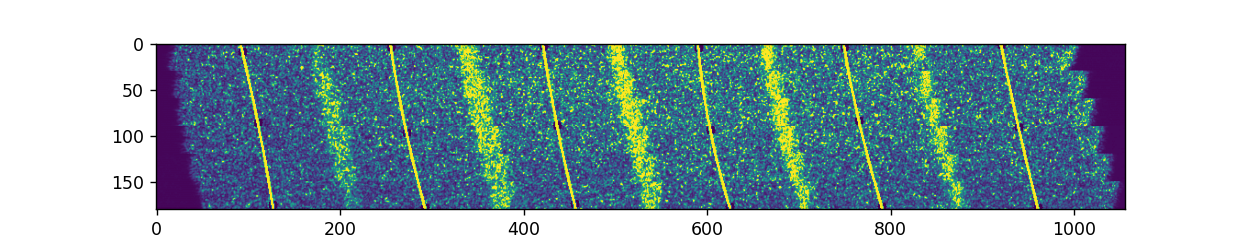

In [ ]:
from recover_core_lib import *

def select_points(event, x, y, flags, param):
    global points, num_points, image
    
    N_CLICKS = param # Total number of clicks (e.g., 30)
    
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1) # Draw a green circle at the click
        num_points += 1
        
        # Check if we have completed a group of 3
        if num_points % 3 == 0:
            # Get the last 3 points
            arc_points = np.array(points[-3:])
            x_pts = arc_points[:, 0]
            y_pts = arc_points[:, 1]
            
            # Sort by y to handle vertical-ish curves
            sort_indices = np.argsort(y_pts)
            x_pts_sorted = x_pts[sort_indices]
            y_pts_sorted = y_pts[sort_indices]
            
            try:
                # Fit x = f(y) (degree 2 parabola)
                poly_coeffs = np.polyfit(y_pts_sorted, x_pts_sorted, 2)
                poly_curve = np.poly1d(poly_coeffs)
                
                # Generate points to draw the curve across the whole image height
                y_draw = np.arange(0, image.shape[0])
                x_draw = poly_curve(y_draw).astype(int)
                
                curve_draw_points = []
                for i in range(len(y_draw)):
                    # Filter points outside the image width
                    if 0 <= x_draw[i] < image.shape[1]:
                        curve_draw_points.append([x_draw[i], y_draw[i]])
                
                if curve_draw_points:
                    cv2.polylines(image, [np.array(curve_draw_points, dtype=np.int32)], isClosed=False, color=(255, 255, 255), thickness=2)
            
            except np.linalg.LinAlgError:
                # Handle cases like 3 identical points
                cv2.putText(image, "Fit Error", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                pass
        
        cv2.imshow("Image", image)
        
        if num_points >= N_CLICKS:
            cv2.setMouseCallback("Image", lambda *args : None)  # Disable
def get_points_from_image(image_np, N):
    global image, points, num_points
    points = []  # Reset points list
    num_points = 0  # Reset point counter
    image = image_np.copy()  # Work on a copy of the image
    
    # Display the image and set the mouse callback function
    cv2.imshow("Image", image)
    cv2.setMouseCallback("Image", select_points, param=N)
    
    # This ensures the window can update properly
    while True:
        # Wait for a key press
        key = cv2.waitKey(1) & 0xFF
        # If all points are selected or the user presses the 'q' key, exit loop
        if num_points >= N or key == ord('q'):
            break
    
    cv2.destroyAllWindows()
    
    return points

run_opt_recovery['N_vert_ROIs']   = 6 # This is now the number of ARCS
N_CLICKS_PER_ARC = 3
N_CLICKS = run_opt_recovery['N_vert_ROIs'] * N_CLICKS_PER_ARC # Total 30 clicks

points = []
num_points = 0

image = stretch_contrast(frame_recording[20].copy())
# Request 30 clicks
selected_points = get_points_from_image(image, N_CLICKS)

# 'image' is a global in recover_core_lib and is modified by the callback
plt.figure(figsize=(10,2))
plt.imshow(image)


In [ ]:
if 'run_opt_multiROIs' in run_opt:
    run_opt_multiROIs = run_opt['run_opt_multiROIs']
else: # runs in manual mode
    run_opt_multiROIs = {}
    run_opt_multiROIs['N_ROIs'] = 6
    run_opt_multiROIs['ROI_height'] = 30
   
print(run_opt_multiROIs)

{'N_ROIs': 6, 'ROI_height': 30}


<IPython.core.display.Javascript object>


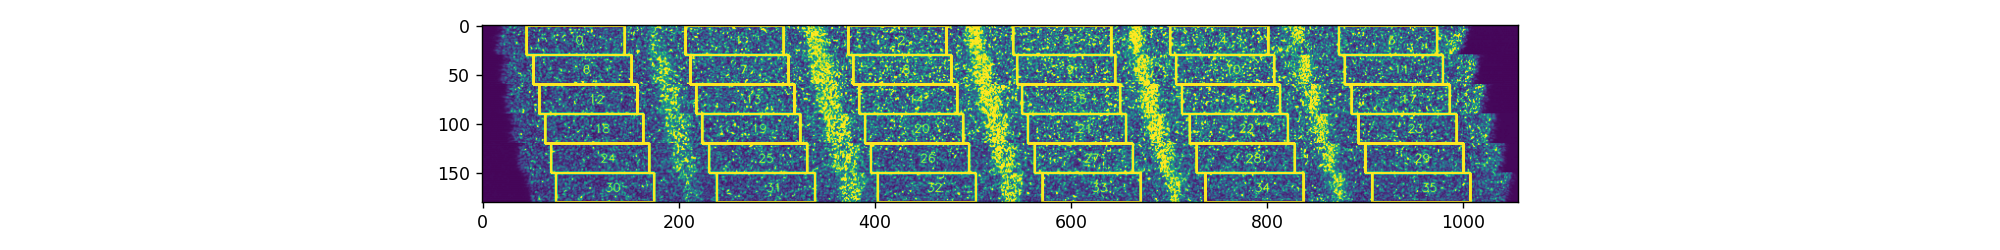

In [ ]:
run_opt_recovery['N_vert_ROI_width']   = 100
w = run_opt_recovery['N_vert_ROI_width']
h = run_opt_multiROIs['ROI_height']
N_CLICKS_PER_ARC = 3

# First, fit all 10 (N_vert_ROIs) parabolas
poly_curves = []
for col in range(run_opt_recovery['N_vert_ROIs']):
    # Get the 3 points for this arc
    arc_points = np.array(selected_points[col*N_CLICKS_PER_ARC : (col+1)*N_CLICKS_PER_ARC])
    x_pts = arc_points[:, 0]
    y_pts = arc_points[:, 1]
    
    # Sort by y to ensure polyfit works for vertical-ish curves
    sort_indices = np.argsort(y_pts)
    x_pts_sorted = x_pts[sort_indices]
    y_pts_sorted = y_pts[sort_indices]

    # Fit x = f(y)
    poly_coeffs = np.polyfit(y_pts_sorted, x_pts_sorted, 2)
    poly_curve = np.poly1d(poly_coeffs)
    poly_curves.append(poly_curve)

# Now, generate ROIs along these curves
ROIs= []
for row in range(run_opt_multiROIs['N_ROIs']):
    for col in range(run_opt_recovery['N_vert_ROIs']):
        # Get the correct parabola for this "column"
        poly_curve = poly_curves[col]
        
        # Calculate the y-position for this row (top of the ROI)
        y_top = row * run_opt_multiROIs['ROI_height']
        
        # Find the center x on the curve for the *center* y of the ROI
        y_center = y_top + h / 2
        x_center_on_curve = poly_curve(y_center)
        
        # Calculate top-left (x, y) of the ROI
        x_top_left = int(x_center_on_curve - w / 2)
        y_top_left = int(y_top)
        
        ROIs.append((x_top_left, y_top_left, w, h))

# manual change
if 0:
    ROIs = ROIs[6:]
    ROIs.append((385-run_opt_recovery['N_vert_ROI_width']//2,0,w,h))

run_opt_multiROIs['ROIs'] = ROIs

frame_show = stretch_contrast(frame_recording[20].copy())        
for i, (x, y, w, h) in enumerate(run_opt_multiROIs['ROIs']):
    cv2.rectangle(frame_show, (x, y), (x + w, y + h), (255, 0, 0), 2)
    center_x, center_y = x + w // 2, y + h // 2+4
    cv2.putText(frame_show, str(i), (center_x, center_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)
plt.figure(figsize=(16, 2))
plt.imshow(frame_show)
plt.tight_layout()
plt.show()

## 2D grid

<IPython.core.display.Javascript object>


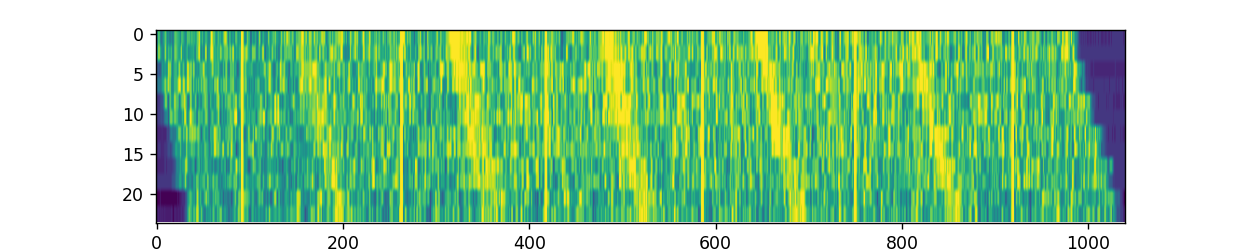

In [ ]:
from recover_core_lib import *

run_opt_recovery['N_vert_ROIs']    = 6

points = []
num_points = 0

raw_frame = frame_recording[20].copy().astype(np.float32)

# 2. Apply Log Transform: I_out = log(1 + I_in)
image_log = np.log1p(raw_frame)

# 3. Normalize the log image to 0-255 range for display (uint8)
image = cv2.normalize(image_log, None, 0, 255, cv2.NORM_MINMAX)
image = image.astype(np.uint8)

min_height = 20 
h, w = image.shape
if h < min_height:
    repeat_factor = math.ceil(min_height / h)
    image = np.repeat(image, repeat_factor, axis=0)

selected_points = get_points_from_image(image, run_opt_recovery['N_vert_ROIs'])

for x, y in selected_points:
    cv2.line(image, (x, 0), (x, image.shape[0]), 255, 2)

plt.figure(figsize=(10, 2))
plt.imshow(image, aspect='auto') 
plt.show()

In [ ]:
if 'run_opt_multiROIs' in run_opt:
    run_opt_multiROIs = run_opt['run_opt_multiROIs']
else: # runs in manual mode
    run_opt_multiROIs = {}
    run_opt_multiROIs['N_ROIs'] = 2
    run_opt_multiROIs['ROI_height'] = 2
    
print(run_opt_multiROIs)

{'N_ROIs': 2, 'ROI_height': 2}


<IPython.core.display.Javascript object>


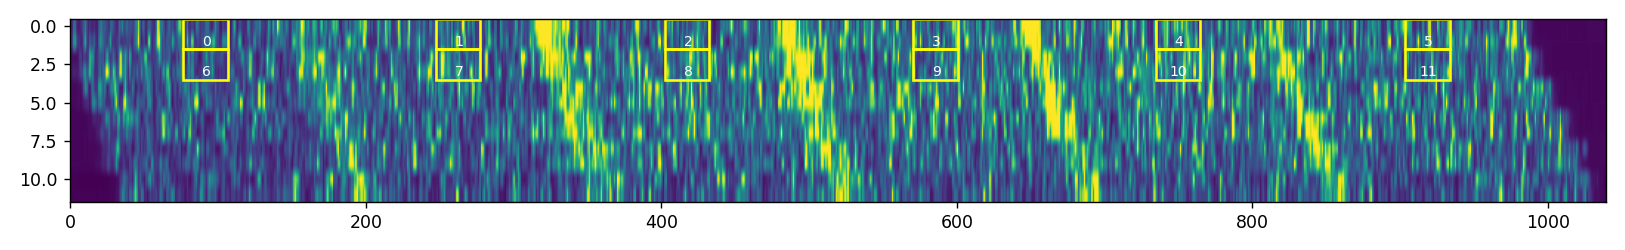

In [ ]:
import matplotlib.patches as patches

run_opt_recovery['N_vert_ROI_width'] = 70

ROIs = []
for row in range(run_opt_multiROIs['N_ROIs']):
    for col in range(run_opt_recovery['N_vert_ROIs']):
        x = selected_points[col][0] - run_opt_recovery['N_vert_ROI_width'] // 2
        y = row * run_opt_multiROIs['ROI_height']
        w = run_opt_recovery['N_vert_ROI_width']
        h = run_opt_multiROIs['ROI_height']
        ROIs.append((x, y, w, h))

# manual change
if 0:
    ROIs = ROIs[6:]
    ROIs.append((385 - run_opt_recovery['N_vert_ROI_width'] // 2, 0, w, h))

run_opt_multiROIs['ROIs'] = ROIs

# 1. Get the clean image (Do not draw cv2 rectangles on it)
frame_show = stretch_contrast(frame_recording[20].copy())

# 2. Setup the plot
fig, ax = plt.subplots(figsize=(13, 2))
ax.imshow(frame_show, aspect='auto')

# 3. Add Vector Rectangles and Text on top
for i, (x, y, w, h) in enumerate(run_opt_multiROIs['ROIs']):
    # Create the rectangle patch
    # (x - 0.5, y - 0.5) aligns the border exactly around the pixels
    rect = patches.Rectangle((x - 0.5, y - 0.5), w, h, 
                             linewidth=1.5,      # Fixed screen width (remains thin)
                             edgecolor='yellow', # Color
                             facecolor='none')   # Transparent center
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Add the text label
    # Calculating center for the text position
    center_x = x + w / 2
    center_y = y + h / 2
    ax.text(center_x, center_y, str(i), 
            color='white', fontsize=8, 
            ha='center', va='center')

plt.tight_layout()
plt.show()

# Show 1D signal

In [ ]:
run_opt['run_opt_multiROIs'] = run_opt_multiROIs
video    = frame_recording


ROIs   = run_opt['run_opt_multiROIs']['ROIs']
N_ROIs = run_opt['run_opt_multiROIs']['N_ROIs']
N_cols = len(ROIs)//N_ROIs

# Unpack constants once
N_frames = video.shape[0]

# Initialize errors array
errors = np.zeros((N_ROIs, N_cols, N_frames))

def calculate_reference_errors(video, ROIs, N_ROIs, N_cols, ref_start=100, ref_end=1000):
    """
    Computes the norm of the difference between each frame and a reference mean image.
    Formula: || Frame[t] - Mean_Frame ||_2
    """
    N_frames = video.shape[0]
    errors = np.zeros((N_ROIs, N_cols, N_frames))

    for k, ROI in enumerate(ROIs):
        l, u, w, h = ROI[0], ROI[1], ROI[-2], ROI[-1]
        
        # Extract stack and cast to float to prevent subtraction wrapping
        roi_stack = video[:, u:u+h, l:l+w].astype(np.float32)
        
        # Calculate the reference mean image from the specified window
        ref_img = roi_stack[ref_start:ref_end].mean(axis=0)
        
        # Vectorized Calculation:
        # 1. Broadcasting: Subtract (h, w) from (N_frames, h, w)
        # 2. Norm: Calculate norm along spatial axes (1, 2)
        diff_norms = np.linalg.norm(roi_stack - ref_img, axis=(1, 2))
        
        row, col = k // N_cols, k % N_cols
        errors[row, col, :] = diff_norms

    return errors

errors = calculate_reference_errors(video, ROIs, N_ROIs, N_cols)

<IPython.core.display.Javascript object>


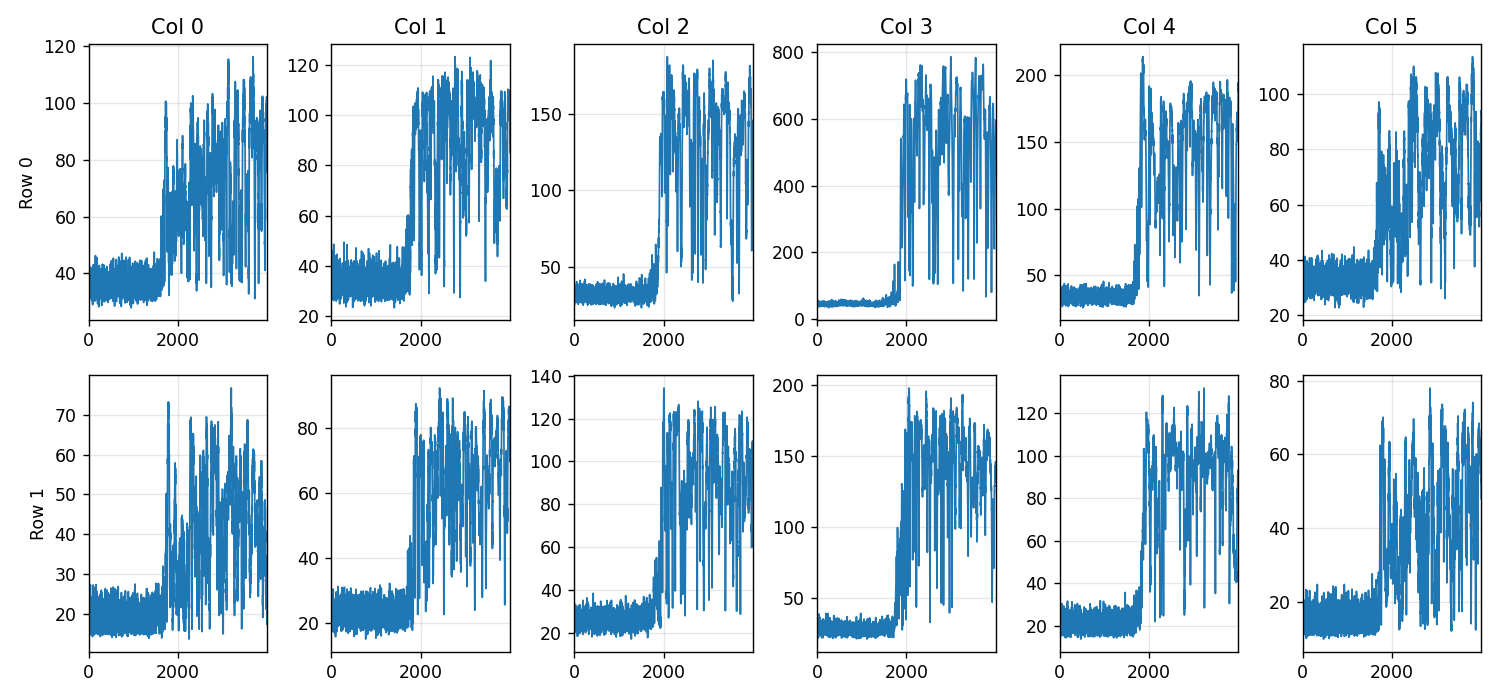

In [ ]:
import matplotlib.pyplot as plt

# 1. Setup the grid
# CHANGE: Set sharex and sharey to False so each plot scales to its own data
fig, axes = plt.subplots(N_ROIs, N_cols, 
                         figsize=(N_cols * 2, N_ROIs * 2.8), 
                         sharex=False,  
                         sharey=False, 
                         squeeze=False) 

# 2. Iterate and Plot
for i in range(N_ROIs):
    for j in range(N_cols):
        ax = axes[i, j]
        
        # Plot the signal
        ax.plot(errors[i, j,92500:96500], linewidth=1)
        
        # CHANGE: remove margins so the signal touches the box edges (max stretch)
        ax.margins(x=0, y=0.05) 
        
        # Styling
        ax.grid(True, alpha=0.3)
        
        # Labels
        if i == 0: ax.set_title(f"Col {j}")
        if j == 0: ax.set_ylabel(f"Row {i}")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


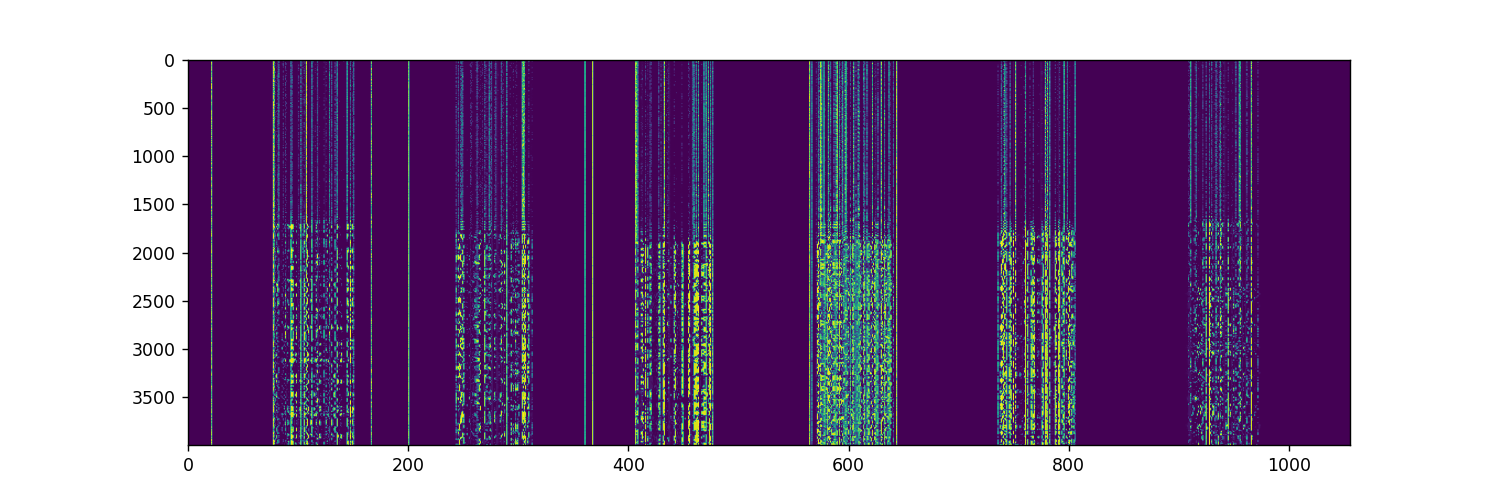

In [ ]:
# frame_show =video[123000:126000,1,:]-video[123000,1,:]
# mask = np.zeros_like(frame_show)
# for ROI in ROIs:
#     mask[0.:,ROI[0]:ROI[0]+ROI[2]]=1
        
# plt.figure(figsize=(12,4))
# plt.imshow(frame_show * mask, aspect='auto')
# plt.show()

frame_show =video[92500:96500,1,:]-video[92500,1,:]

        
plt.figure(figsize=(12,4))
plt.imshow(frame_show, aspect='auto')
plt.show()

## Set signal crop

In [ ]:
signal_crop = slice(92500,96500)
run_opt['signal_crop'] = signal_crop
print(f'signal crop = {signal_crop}')

signal crop = slice(92500, 96500, None)


# Export one point

In [ ]:
# DEBUG: export to Desktop
output_dir = 'C:/Users/markshe/Desktop/'

fs = run_opt['cam_params']['camera_FPS']
new_fs = fs  # New sampling frequency in Hz
original_fs = fs  # Original sampling frequency in Hz

X,Y = np.meshgrid(np.arange(6),np.arange(6))
X,Y = X.flatten(), Y.flatten()

N_pnts = all_shifts.shape[0]

for i in range(N_pnts):
    for axis_type in ['x','y']:        
        
        sig = all_shifts[i,:,0 if axis_type=='x' else 1]
        
        #sig = bandpass_filter(sig,fs,5,10000)
        
        num_samples = int(len(sig) * new_fs / original_fs)
        resampled_sig = resample(sig, num_samples)
        
        pntname = 'pnt{}_xy_{}_{}_axis_{}'.format(i,X[i],Y[i],axis_type)
        save_signal_as_wav(output_dir + pntname + '.wav', resampled_sig, sampling_rate=new_fs)

Audio file saved as: C:/Users/markshe/Desktop/pnt0_xy_0_0_axis_x.wav
Audio file saved as: C:/Users/markshe/Desktop/pnt0_xy_0_0_axis_y.wav
